In [1]:
!pip install pandas
!pip install nltk
!pip install scikit-learn
!pip install pyarrow
!pip install fastparquet
!pip install openpyxl
!pip install contractions
!pip install -U accelerate
!pip install -U transformers
!pip install datasets

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
import numpy as np
import re
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
from collections import defaultdict
import time
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


from transformers import DataCollatorWithPadding
from transformers import AdamW, get_scheduler

from torch.utils.data import DataLoader
from sklearn.metrics import  f1_score


##### Import the multilabel data
##### [UCBerkeley - Hate Speech Dataset (Multilabel)](https://huggingface.co/datasets/ucberkeley-dlab/measuring-hate-speech)


In [2]:
# Download the data locally
#https://huggingface.co/datasets/ucberkeley-dlab/measuring-hate-speech/tree/main

In [3]:
from datasets import load_dataset
## Read the measuring-hate-speech.parquet
raw_datasets = pd.read_parquet('measuring-hate-speech.parquet')

print(f"Number of Columns: {raw_datasets.shape}")


Number of Columns: (135556, 131)


In [4]:
raw_datasets.columns

Index(['comment_id', 'annotator_id', 'platform', 'sentiment', 'respect',
       'insult', 'humiliate', 'status', 'dehumanize', 'violence',
       ...
       'annotator_religion_hindu', 'annotator_religion_jewish',
       'annotator_religion_mormon', 'annotator_religion_muslim',
       'annotator_religion_nothing', 'annotator_religion_other',
       'annotator_sexuality_bisexual', 'annotator_sexuality_gay',
       'annotator_sexuality_straight', 'annotator_sexuality_other'],
      dtype='object', length=131)

In [5]:
# keep only text and specific targets
raw_columns = raw_datasets.columns
keep_columns = ['text', 'target_race', 'target_religion', 'target_origin', 'target_gender', 'target_sexuality', 'target_age', 'target_disability']
drop_columns = [col for col in raw_columns if col not in keep_columns]

raw_datasets = raw_datasets.drop(columns=drop_columns)

column_mapping = {column:column.split('_')[1] for column in keep_columns if column.startswith('target')}
raw_datasets = raw_datasets.rename(columns=column_mapping)
raw_datasets.head()

,text,race,religion,origin,gender,sexuality,age,disability
0,Yes indeed. She sort of reminds me of the elde...,True,False,False,False,False,False,False
1,The trans women reading this tweet right now i...,False,False,False,True,False,False,False
2,Question: These 4 broads who criticize America...,False,False,True,False,False,False,False
3,It is about time for all illegals to go back t...,False,False,True,False,False,False,False
4,For starters bend over the one in pink and kic...,False,False,False,True,False,False,False


In [6]:
# Get two-way label and label ID
ID2LABEL = {idx: column for idx, column in enumerate(raw_datasets.columns[1:])}
LABEL2ID = {column: idx for idx, column in enumerate(raw_datasets.columns[1:])}

print(f"ID2LABEL:\n{ID2LABEL}\n")
print(f"LABEL2ID:\n{LABEL2ID}")

ID2LABEL:
{0: 'race', 1: 'religion', 2: 'origin', 3: 'gender', 4: 'sexuality', 5: 'age', 6: 'disability'}

LABEL2ID:
{'race': 0, 'religion': 1, 'origin': 2, 'gender': 3, 'sexuality': 4, 'age': 5, 'disability': 6}


In [7]:
# Function to create labels
def create_labels(row):
    return [float(row[label]) for label in LABEL2ID]

raw_datasets['labels'] = raw_datasets.apply(create_labels, axis=1)
raw_datasets.head()

,text,race,religion,origin,gender,sexuality,age,disability,labels
0,Yes indeed. She sort of reminds me of the elde...,True,False,False,False,False,False,False,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,The trans women reading this tweet right now i...,False,False,False,True,False,False,False,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,Question: These 4 broads who criticize America...,False,False,True,False,False,False,False,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
3,It is about time for all illegals to go back t...,False,False,True,False,False,False,False,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
4,For starters bend over the one in pink and kic...,False,False,False,True,False,False,False,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"


### Preprocessing text data

In [8]:
## Preprocess the TEXT data
## Remove HTML tags
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

raw_datasets['text'] = raw_datasets['text'].apply(lambda x: remove_html_tags(x))

## Remove URL
def remove_url(text):
    return re.sub(r'http\S+', '', text)

raw_datasets['text'] = raw_datasets['text'].apply(lambda x: remove_url(x))

## Lowercase
raw_datasets['text'] = raw_datasets['text'].str.lower()

## Remove punctuation
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

raw_datasets['text'] = raw_datasets['text'].apply(lambda x: remove_punctuation(x))

## Handling Contractions using libraries

def expand_contractions(text):
    return contractions.fix(text)

raw_datasets['text'] = raw_datasets['text'].apply(lambda x: expand_contractions(x))

## Remove stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

raw_datasets['text'] = raw_datasets['text'].apply(lambda x: remove_stopwords(x))

## Lemmatization
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])
raw_datasets['text'] = raw_datasets['text'].apply(lambda x: lemmatize_words(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Dataset/Dataloader

In [9]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

MAX_LEN = 256
#TRAIN_BATCH_SIZE = 16
#VALID_BATCH_SIZE = 8
EPOCHS = 3
LEARNING_RATE = 1e-05

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [11]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

# train (80%), validation (10%), test (10%) split

train_data, temp_data = train_test_split(raw_datasets, test_size=0.2, random_state=SEED)
validation_data, test_data = train_test_split(temp_data, test_size=0.25, random_state=SEED)

print(f"Train Dataset: {train_data.shape}")
print(f"Validation Dataset: {validation_data.shape}")
print(f"Test Dataset: {test_data.shape}")

# Reset the index of the DataFrames
train_data = train_data.reset_index(drop=True)
validation_data = validation_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Keep only the text and labels columns 
train_data = train_data[['text', 'labels']]
validation_data = validation_data[['text', 'labels']]
test_data = test_data[['text', 'labels']]

train_dataset = Dataset.from_pandas(train_data)
validation_dataset = Dataset.from_pandas(validation_data)
test_dataset = Dataset.from_pandas(test_data)

# Create a DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': validation_dataset,
    'test': test_dataset
})

Train Dataset: (108444, 9)
Validation Dataset: (20334, 9)
Test Dataset: (6778, 9)


In [12]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 108444
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 20334
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 6778
    })
})

#### Tokenize the Dataset

In [13]:
from transformers import AutoTokenizer

CHECKPOINT = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)

# Define the tokenization function
def tokenize_function(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length')

tokenized_datasets = dataset_dict.map(tokenize_function, batched=True, remove_columns=['text'])


Map:   0%|          | 0/108444 [00:00<?, ? examples/s]

Map:   0%|          | 0/20334 [00:00<?, ? examples/s]

Map:   0%|          | 0/6778 [00:00<?, ? examples/s]

In [14]:
print(tokenized_datasets)


DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 108444
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 20334
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 6778
    })
})


#### DataLoaders

In [15]:

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

dataloaders = {}
for dataset_type in tokenized_datasets.keys():
    dataloaders[dataset_type] = DataLoader(
        dataset=tokenized_datasets[dataset_type],
        batch_size=64,
        shuffle=(dataset_type == 'train'), 
        collate_fn=data_collator,
    )


#### Define the model

In [16]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    CHECKPOINT,
    problem_type='multi_label_classification',
    num_labels=len(LABEL2ID),
    label2id=LABEL2ID,
    id2label=ID2LABEL,
)
model.to(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

#### Setup Hyperparameters

In [17]:
scheduler_name = 'linear'
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0, no_deprecation_warning=True)
num_training_steps = EPOCHS * len(dataloaders['train'])
num_warmup_steps = 0

lr_scheduler = get_scheduler(
    name=scheduler_name,
    optimizer=optimizer,
    num_training_steps=num_training_steps,
    num_warmup_steps=num_warmup_steps,
)

#### Accuracy Metrics

In [18]:

def accuracy_score(y_true, y_pred):
    return np.sum(y_true==y_pred) / y_true.size

def compute_metrics(preds):
    logits, labels = preds
    preds_= torch.nn.functional.sigmoid(torch.Tensor(logits))
    preds_ = (preds_ >= 0.50).int().numpy()
    samples_acc = accuracy_score(labels, preds_)
    samples_f1 = f1_score(labels, preds_, average='samples', zero_division=0)
    return {
        'accuracy': samples_acc,
        'f1': samples_f1,
    }


#### Training Loop

In [19]:
from tqdm import tqdm

def train(model, dataloader):

    loss = 0
    train_preds = []
    train_labels = []
    
    # set to train mode
    model.train()

    for batch in tqdm(dataloader):

        optimizer.zero_grad()
        batch.to(device)
        outputs = model(**batch)

        predictions = torch.nn.functional.sigmoid(outputs.logits).cpu()
        predictions = (predictions >= 0.50).int().numpy()
        labels = batch['labels']
        
        outputs.loss.backward()
        optimizer.step()
        lr_scheduler.step()
        
        loss += outputs.loss.item()
        train_preds += predictions.tolist()
        train_labels += labels.tolist()
        
    loss /= len(dataloader)
    samples_acc = accuracy_score(np.array(train_labels), np.array(train_preds))
    samples_f1 = f1_score(np.array(train_labels), np.array(train_preds), average='samples', zero_division=0)
    return {
        'loss': loss,
        'accuracy': samples_acc,
        'f1': samples_f1,
    }

#### Validation Loop

In [20]:
def evaluate(model, dataloader):

    loss = 0
    val_preds = []
    val_labels = []
    
    model.eval()
    with torch.no_grad():

        for batch in tqdm(dataloader):

            batch.to(device)
            outputs = model(**batch)
            
            predictions = torch.nn.functional.sigmoid(outputs.logits).cpu()
            predictions = (predictions >= 0.50).cpu().numpy()
            labels = batch['labels']
            
            loss += outputs.loss.item()
            val_preds += predictions.tolist()
            val_labels += labels.tolist()
            
    # evaluation metrics
    loss /= len(dataloader)
    samples_acc = accuracy_score(np.array(val_labels), np.array(val_preds))
    samples_f1 = f1_score(np.array(val_labels), np.array(val_preds), average='samples', zero_division=0)
    return {
        'loss': loss,
        'accuracy': samples_acc,
        'f1': samples_f1,
    }

##### Train Model

In [22]:
for epoch in range(EPOCHS):
    
    train_metrics = train(model, dataloaders['train'])
    validation_metrics = evaluate(model, dataloaders['validation'])
          
    print(f"Epoch {epoch+1}", end=" | ")
    print(f"Train loss: {train_metrics['loss']:.5f}", end=" | ")
    print(f"Validation loss: {validation_metrics['loss']:.5f}", end=" | ")
    print(f"Validation accuracy: {validation_metrics['accuracy']:.5f}", end=" | ")
    print(f"Validation F1: {validation_metrics['f1']:.5f}")

100%|██████████| 318/318 [00:50<00:00,  6.31it/s]


Epoch 1 | Train loss: 0.18145 | Validation loss: 0.16350 | Validation accuracy: 0.93565 | Validation F1: 0.82615


100%|██████████| 318/318 [00:50<00:00,  6.30it/s]


Epoch 2 | Train loss: 0.15098 | Validation loss: 0.15835 | Validation accuracy: 0.93640 | Validation F1: 0.82746


100%|██████████| 318/318 [00:50<00:00,  6.28it/s]

Epoch 3 | Train loss: 0.13782 | Validation loss: 0.15946 | Validation accuracy: 0.93635 | Validation F1: 0.83097


In [24]:
#results_models_weights_dir = 'models_weights_multilabel_bert/'
#if not os.path.exists(results_models_weights_dir):
#    os.mkdir(results_models_weights_dir)
#torch.save(model.state_dict(), results_models_weights_dir + 'multilabel_bert_five_epochs.pth')

##### Testing

In [21]:
# Load the model form the corresponding class udsing the  weights saved under multilabel_bert_five_epochs.pth
model_path = 'multilabel_bert_five_epochs.pth'
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)

<All keys matched successfully>

### Interpretability

In [50]:
# Import  the libraries for the interpretation
! pip install lime
! pip install transformers-interpret


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


##### DISCLAIMER (HATE SPEECH ABOVE)

In [27]:
samples = ['Gay people are a waste of space', 'We need to castrate all men','German for germans, foreigners out']
attributions = dict()
attributions['LIME'] = []

In [28]:
import lime
from lime.lime_text import LimeTextExplainer
columns_to_transform = raw_datasets.columns[1:-1]
print(columns_to_transform)
explainer = LimeTextExplainer(class_names=columns_to_transform, split_expression='\s+', bow=False)

Index(['race', 'religion', 'origin', 'gender', 'sexuality', 'age',
       'disability'],
      dtype='object')


In [29]:

def predictor(texts):

    encodings = tokenizer(texts,
                           padding='max_length',
                           truncation=True,
                           max_length=MAX_LEN,
                           return_tensors='pt').to(device)

    logits = model(**encodings).logits
    probabilities = F.softmax(logits, dim=1)

    return probabilities.cpu().detach().numpy()

for idx,sample in enumerate(samples):

    instance = sample

    # Call predictor with the current instance
    exp = explainer.explain_instance(instance, predictor, num_features=200, num_samples=80)

    explanation_dict = dict(list(exp.as_map().values())[0])
    tokens = sample.split(' ')
    scores = []

    for i in range(len(tokens)):
        scores.append((tokens[i], explanation_dict[i]))

    attributions['LIME'].append(scores)


In [30]:

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm, transforms

# Plotting Code from innvestigate library: https://github.com/albermax/innvestigate
def plot_text_heatmap(words, scores, title="", width=10, height=0.2, verbose=0, max_word_per_line=20):
    fig = plt.figure(figsize=(width, height))

    ax = plt.gca()

    ax.set_title(title, loc='left')
    tokens = words
    if verbose > 0:
        print('len words : %d | len scores : %d' % (len(words), len(scores)))

    cmap = plt.cm.ScalarMappable(cmap=cm.bwr)
    cmap.set_clim(0, 1)

    canvas = ax.figure.canvas
    t = ax.transData

    # normalize scores to the followings:
    # - negative scores in [0, 0.5]
    # - positive scores in (0.5, 1]
    normalized_scores = 0.5 * scores / np.max(np.abs(scores)) + 0.5

    if verbose > 1:
        print('Raw score')
        print(scores)
        print('Normalized score')
        print(normalized_scores)

    # make sure the heatmap doesn't overlap with the title
    loc_y = -0.2

    for i, token in enumerate(tokens):
        *rgb, _ = cmap.to_rgba(normalized_scores[i], bytes=True)
        color = '#%02x%02x%02x' % tuple(rgb)

        text = ax.text(0.0, loc_y, token,
                       bbox={
                           'facecolor': color,
                           'pad': 5.0,
                           'linewidth': 1,
                           'boxstyle': 'round,pad=0.5'
                       }, transform=t)

        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()

        # create a new line if the line exceeds the length
        if (i+1) % max_word_per_line == 0:
            loc_y = loc_y -  2.5
            t = ax.transData
        else:
            t = transforms.offset_copy(text._transform, x=ex.width+15, units='dots')

    if verbose == 0:
        ax.axis('off')


[[{'label': 'sexuality', 'score': 0.9942939877510071}, {'label': 'gender', 'score': 0.023558977991342545}, {'label': 'religion', 'score': 0.0015401901910081506}, {'label': 'disability', 'score': 0.0013402808690443635}, {'label': 'race', 'score': 0.0012715808115899563}, {'label': 'origin', 'score': 0.0011607258347794414}, {'label': 'age', 'score': 0.0006942928303033113}]]


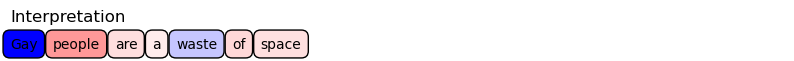

[[{'label': 'gender', 'score': 0.8972600698471069}, {'label': 'sexuality', 'score': 0.10691762715578079}, {'label': 'religion', 'score': 0.06809651851654053}, {'label': 'race', 'score': 0.025975868105888367}, {'label': 'origin', 'score': 0.004534215200692415}, {'label': 'age', 'score': 0.0031294787768274546}, {'label': 'disability', 'score': 0.0010967524722218513}]]


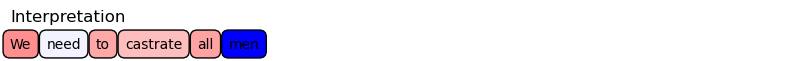

[[{'label': 'origin', 'score': 0.9019618630409241}, {'label': 'race', 'score': 0.19886402785778046}, {'label': 'religion', 'score': 0.00717422878369689}, {'label': 'gender', 'score': 0.0021691499277949333}, {'label': 'sexuality', 'score': 0.0008241874747909606}, {'label': 'age', 'score': 0.000458190159406513}, {'label': 'disability', 'score': 0.0003114095889031887}]]


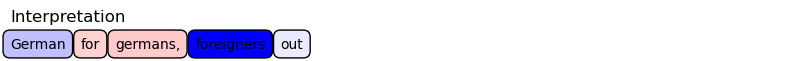

In [31]:

from transformers import pipeline

multilabel_BERT = pipeline( task='text-classification', model=model, tokenizer=tokenizer, device=device,top_k=None)

# Plotting
methods = ['LIME']

for sample_id in range(len(samples)):
    for method in methods:
        analysis = attributions[method][sample_id]

        words = [t[0] for t in analysis]
        scores = np.array([t[1] for t in analysis])
        # Create title for the plot using the multilabel_BERT prediction
        preds = multilabel_BERT(samples[sample_id])
        print(preds)
        plot_text_heatmap(words, scores, title='Interpretation' , verbose=0)


    plt.show()